In [ ]:
1. user input and movie input
2. convert every user and movie to one hot encoding
3. pass these one hot encoded through glorot uniform
4. movie lens rating dataset - convert it into implicit data with values 0 or 1 where 0 = user has not interacted with the item and 1 otherwise
5. userid, movieid, rating,timestamp
6. generate training instances why?


gmf :

# Training
        hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels
                         batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True)


# mf - dot product of two vectors places it nearby each other as said in the paper about the figure where one vector is placed near to another vector but there is a possibility that the placemnt is wrong
# gmf - which is a limitation of the dot product,therefore to overcome this dot product pass this through a neural layer to learn the pattern and place the vectors nearby each other .
# mlp - to introduce more user and item interaction dont use the dot product instead concatenate both user and item vectors and pass through mlp, uses non linear kernel- nonlinear kernels add flexibility by implicitly mapping the data to higher dimensional spaces where nonlinear relationships become linear and complex boundaries can be learned.
# use ncf - fuse gmf(linearity) and mlp(non linearty)

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#defining parameters and libraries for building models
import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Flatten
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.regularizers import l2
import keras.regularizers

batch_size = 250
learning_rate = 0.0001


In [ ]:
rating = pd.read_csv("rating.csv")
unique_user = rating["userId"].nunique()
unique_item = rating["movieId"].nunique()
print("length of the data", len(rating.userId))
print("number of unique users", unique_user)
print("number of unique movies", unique_item)
print(rating.head())

length of the data 20000263
number of unique users 138493
number of unique movies 26744
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


In [ ]:
user_array = np.array(rating.userId)
item_array = np.array(rating.movieId)
max_item_val = np.max(item_array)
max_user_val = np.max(user_array)
print(max_item_val,max_user_val)
num_negative = 2
ziped = zip(user_array,item_array)
user_item_dict = {}
for user,item in ziped:
  user_item_dict[(user,item)] = 1.0

def generate_instances(user_item_dict,num_negative,max_item_val):
  user_instances, item_instances, labels = [],[],[]
  iter,iter_neg = 0,0
  keys = user_item_dict.keys()
  for (user,item) in keys:
    iter+=1
    user_instances.append(user)
    item_instances.append(item)
    labels.append(1.0)
    #generate negative instances
    for t in range(num_negative):
            j = np.random.randint(max_item_val+1)
            #print("random number j",j)
            while (user,j) in user_item_dict:
                j = np.random.randint(max_item_val) #keep on generating till the pair (u,i) is not in the dataset so it can be observed as a negative instance where(u,i) = 0
                #print(j)
            iter_neg+=1  #count the number of negative instances
            user_instances.append(user)
            item_instances.append(j)
            labels.append(0)
  return user_instances, item_instances, labels,iter_neg,iter
user_instances, item_instances, labels,iter_neg,iter = generate_instances(user_item_dict, 2, max_item_val)
#user_item_dict = zip((user_array,item_array)=1)


131262 138493


In [ ]:
# train and test split
from sklearn.model_selection import train_test_split
# print(iter_neg,iter)
# print(len(user_instances), len(item_instances), len(labels))

dataset = pd.DataFrame({'user':user_instances,"item":item_instances,"labels":labels})
print(dataset.head())
X_train, X_test, y_train, y_test = train_test_split(dataset[['user', 'item']], dataset[["labels"]], stratify =dataset[["labels"]] ,test_size=0.33, random_state=42)


In [ ]:
print(X_train.head())
print("length of the total data",len(user_instances))
print("length of the training data is ", len(X_train))
print("length of the test data is ", len(X_test))

In [ ]:
def plot_loss_accuracy(model,model_name):
      print("model keys",model_name,model.history.keys())
      # summarize history for accuracy
      plt.plot(model.history['accuracy'])
      #plt.plot(test_accuracy)
      plt.title('model accuracy')
      plt.ylabel('accuracy')
      plt.xlabel('epoch')
      plt.legend(['train'], loc='upper right')
      plt.show()
      # summarize history for loss
      plt.plot(model.history['loss'])
      #plt.plot(test_loss)
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train'], loc='upper right')
      plt.show()

In [ ]:
#GMF model

def gmf_model(user_input,item_input): #element wise multiplication + one dense layer
  user_in = Input(shape = (1,),dtype = "int32",name = "user_in")
  item_in = Input(shape = (1,),dtype = "int32",name = "item_in")

  user_embedding = Embedding(input_dim = user_input, output_dim = 8, name = "user_embed",embeddings_initializer='uniform',input_length = 1)#since the input is a single number
  item_embedding = Embedding(input_dim = item_input, output_dim = 8 , name = "item_embed",embeddings_initializer='uniform', input_length = 1)

  user_flatten = Flatten()(user_embedding(user_in)) #flatten the embedding layers
  item_flatten = Flatten()(item_embedding(item_in))

  print("shape of user embedding is {} and item embedding is {}".format(user_flatten.shape, item_flatten.shape))

  user_item_product = keras.layers.Multiply()([user_flatten, item_flatten])#element wise product
  print("shape after merging the two flattened embedddings",user_item_product.shape)
  predict_layer = Dense(1, activation = "sigmoid",kernel_initializer = "lecun_uniform",name = "predict_rating")(user_item_product)
  gmf_model = Model(inputs = [user_in,item_in],outputs = predict_layer)

  return gmf_model

#build the model

model = gmf_model(max_user_val+1, max_item_val+1)
model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy',metrics = ["accuracy"])

print("Summary of GMF model", model.summary())
#train the gmf model

gmf_model_history= model.fit([np.array(X_train.user), np.array(X_train.item)], #input
                         np.array(y_train), # labels
                         batch_size=batch_size, epochs=50 , verbose=0, shuffle=True) #saturation at 50 epochs


shape of user embedding is (None, 8) and item embedding is (None, 8)
shape after merging the two flattened embedddings (None, 8)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_in (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 item_in (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 user_embed (Embedding)      (None, 1, 8)                 32312     ['user_in[0][0]']             
                                                                                                  
 item_embed (Embedding)      (None, 1, 8)                 104514

18648/18648 [==============================] - 35s 2ms/step - loss: 0.6371 - accuracy: 0.6667
model keys Gmf_Model dict_keys(['loss', 'accuracy'])


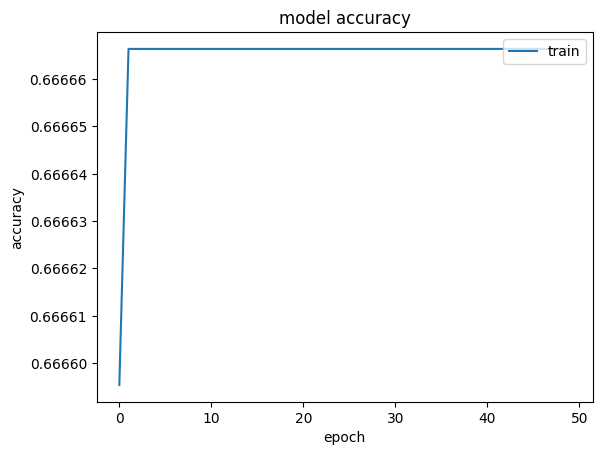

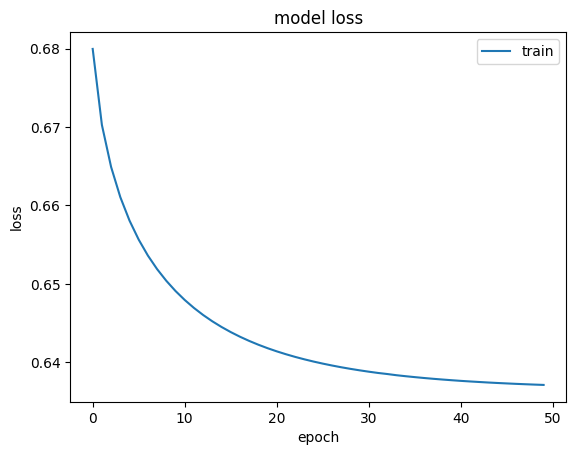

In [ ]:
test_loss, test_accuracy = model.evaluate([np.array(X_test.user), np.array(X_test.item)], y_test)
plot_loss_accuracy(gmf_model_history,"Gmf_Model")


In [ ]:
# MLP Model

def mlp_model(user_input, item_input,layers = [64,32,16]):
  user_in = Input(shape = (1,),dtype = "int32",name = "user_in")
  item_in = Input(shape = (1,),dtype = "int32",name = "item_in")

  #Embedding layer is layers[0]/ 2 because later we have to concat the embedding therefore total size to the first dense layer will total to layers[0]
  mlp_user_embedding = Embedding(input_dim = user_input, output_dim = int(layers[0]/2), name = "user_embed",embeddings_initializer='uniform',input_length = 1)#since the input is a single number
  mlp_item_embedding = Embedding(input_dim = item_input, output_dim = int(layers[0]/2), name = "item_embed",embeddings_initializer='uniform', input_length = 1)

  user_flatten = Flatten()(mlp_user_embedding(user_in)) #flatten the embedding layers
  item_flatten = Flatten()(mlp_item_embedding(item_in))

  #layer - 0 concat both the embedding(64) total size after concat

  concat_vector = tf.concat([user_flatten,item_flatten],1) #column wise concat

  #MLP dense layers : with size 32 and 16

  for i in range(1, len(layers)):
    dense_layer = Dense(layers[i], kernel_regularizer=l2(0.01),activation='relu', name = 'layer%d' %i)
    concat_vector = dense_layer(concat_vector)

  # final output layer

  output_layer = Dense(1,kernel_initializer ='lecun_uniform',activation='sigmoid',name = "prediction")(concat_vector)
  mlp_model = Model(inputs = [user_in, item_in], outputs = output_layer)

  return mlp_model

# Build and Compile the MLP model
MLP_model = mlp_model(max_user_val+1, max_item_val+1,layers = [64,32,16])
MLP_model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', metrics = ["accuracy"])

print("Summary of MLP model", MLP_model.summary())


mlp_model_history = MLP_model.fit([np.array(X_train.user), np.array(X_train.item)], #input
                         np.array(y_train), # labels
                         batch_size=batch_size, epochs=50, verbose=0, shuffle=True)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_in (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 item_in (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 user_embed (Embedding)      (None, 1, 32)                129248    ['user_in[0][0]']             
                                                                                                  
 item_embed (Embedding)      (None, 1, 32)                4180576   ['item_in[0][0]']             
                                                                                            

18648/18648 [==============================] - 36s 2ms/step - loss: 0.6365 - accuracy: 0.6667
model keys MLP_Model dict_keys(['loss', 'accuracy'])


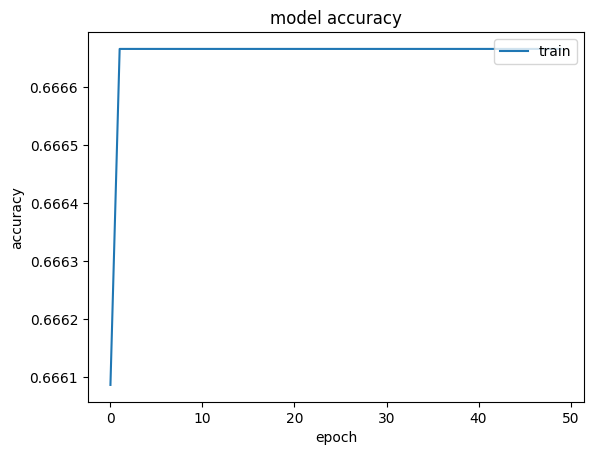

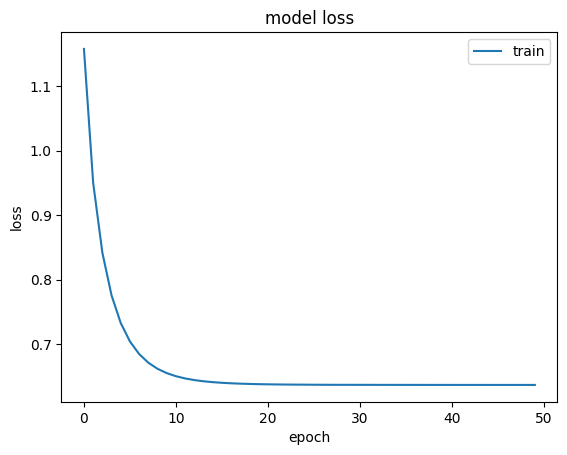

In [ ]:
test_loss, test_accuracy = MLP_model.evaluate([np.array(X_test.user), np.array(X_test.item)], y_test)
plot_loss_accuracy(mlp_model_history,"MLP_Model")

In [ ]:
#Neural CF

def neural_cf(user_input, item_input, gmf_dim, layers): #gmf_dim = 10, layers = [20,10]
  #GMF Part
  user_in = Input(shape = (1,),dtype = "int32",name = "user_in")
  item_in = Input(shape = (1,),dtype = "int32",name = "item_in")

  user_embedding = Embedding(input_dim = user_input, output_dim = gmf_dim, name = "user_embed",embeddings_initializer='uniform',input_length = 1)#since the input is a single number
  item_embedding = Embedding(input_dim = item_input, output_dim = gmf_dim , name = "item_embed",embeddings_initializer='uniform', input_length = 1)

  user_flatten = Flatten()(user_embedding(user_in)) #flatten the embedding layers
  item_flatten = Flatten()(item_embedding(item_in))
  user_item_product = keras.layers.Multiply()([user_flatten, item_flatten])#element wise product



  #MLP Part

  #Embedding layer is layers[0]/ 2 because later we have to concat the embedding therefore total size to the first dense layer will total to layers[0]
  mlp_user_embedding = Embedding(input_dim = user_input, output_dim = int(layers[0]/2), name = "mlp_user_embed",embeddings_initializer='uniform',input_length = 1)#since the input is a single number
  mlp_item_embedding = Embedding(input_dim = item_input, output_dim = int(layers[0]/2), name = "mlp_item_embed",embeddings_initializer='uniform', input_length = 1)

  mlp_user_flatten = Flatten()(mlp_user_embedding(user_in)) #flatten the embedding layers
  mlp_item_flatten = Flatten()(mlp_item_embedding(item_in))

  #layer - 0 concat both the embedding(64) total size after concat

  concat_vector = tf.concat([mlp_user_flatten,mlp_item_flatten],1) #column wise concat

  #MLP dense layers : with size 20 and 10

  for i in range(1, len(layers)):
    dense_layer = Dense(layers[i], kernel_regularizer=l2(0.01),activation='relu', name = 'layer%d' %i)
    concat_vector = dense_layer(concat_vector)

  #concat gmf and mlp part and train it through 1 dense layer

  gmf_plus_mlp =   tf.concat([user_item_product,concat_vector],axis = 1)
  final_prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(gmf_plus_mlp)

  model = Model(inputs = [user_in, item_in],
                  outputs = final_prediction)

  return model

Neucf_model = neural_cf(max_user_val+1, max_item_val+1,10, [20,10])
Neucf_model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy',metrics = ["accuracy"])

# Fit the model

Neucf_model_history = Neucf_model.fit([np.array(X_train.user), np.array(X_train.item)], #input
                         np.array(y_train), # labels
                         batch_size=batch_size, epochs=100, verbose=0, shuffle=True)


18648/18648 [==============================] - 36s 2ms/step - loss: 0.6305 - accuracy: 0.6667
model keys Neucf_Model dict_keys(['loss', 'accuracy'])


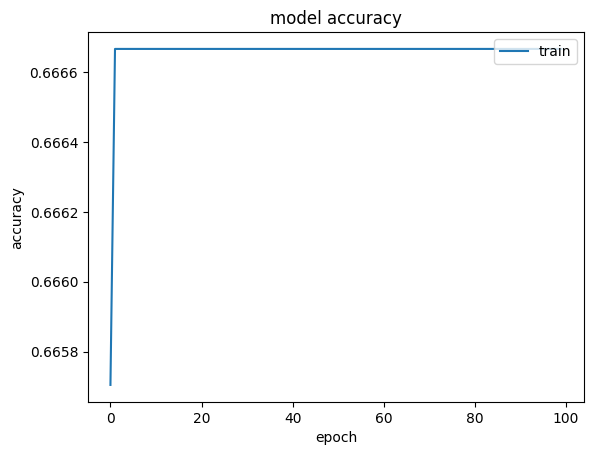

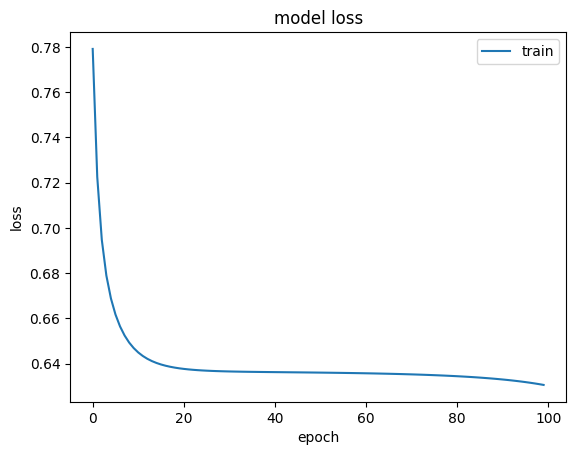

In [ ]:
test_loss, test_accuracy = Neucf_model.evaluate([np.array(X_test.user), np.array(X_test.item)], y_test)
plot_loss_accuracy(Neucf_model_history,"Neucf_Model")